# Suicide Watch analysis
This notebook will walk you through building the models we
built after collecting our data from the Suicide Watch Subreddit

We first import the libraries and utility files we are going to be using,
and parse and clean our data.

In [111]:
%matplotlib inline

# Import machine learning libraries
import gensim
import textmining
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy.linalg as LA
import scipy.sparse as sparse
from sklearn.manifold import MDS
from sklearn.cluster import KMeans
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer

# Import utility files
import dataUtils
import clusterUtils

In [275]:
# Get the data from the csv
df = dataUtils.read_df('data')

In [276]:
# Clean the text in the datafram
df =df.replace(np.nan, '', regex=True)
df["rawtext"]= df["title"]+" "+df["selftext"]
df["cleantext"]=df["rawtext"].apply(dataUtils.remove_links).apply(dataUtils.cleanSentence)

In [277]:
# Get a stream of text
posts= df["cleantext"].apply(lambda str: str.split()).tolist()

In [221]:
# Train a phraseDetector
two_word_phrases = gensim.models.Phrases(posts)

In [222]:
two_word_phraser = gensim.models.phrases.Phraser(two_word_phrases)

In [223]:
# phrase_length =3
#posts = list(two_word_phraser[posts])
three_word_phrases = gensim.models.Phrases(two_word_phraser[posts])
three_word_phraser = gensim.models.phrases.Phraser(three_word_phrases)
posts              = list(three_word_phraser[two_word_phraser[posts]])

In [ ]:
# update clean text
df["cleantext"]=df["cleantext"].apply(lambda str: " ".join(three_word_phraser[two_word_phraser[str.split()]]))

#### Data summary statistics

Before building models, we first look at that data that we are using.

In [ ]:
# Get the number of posts
num_posts = len(posts)
num_posts

In [ ]:
#get the number of users (minus [deleted])
userList= df["author"].tolist()
userDict = {}
for user in userList:
    if user in userDict.keys() and user != "[deleted]":
        userDict[user] =1+userDict[user]
    else:
        userDict[user] =1
len(list(userDict.keys()))

#### Build word2vec model
At this step we will build the word2vec model that we will use in the rest of the analysis.
Becuase this is a compuationally expensive process, we save the results of running our model
as the value of model_name +".model" in the models directory. We can then load this model later, and do not need
to re build it every time we want to analyze it.

In [224]:
model_name = "model3"

In [ ]:
dataUtils.save_object(posts,'objects/',model_name+"-posts")

In [4]:
posts = dataUtils.load_object('objects/',model_name+"-posts")

In [ ]:
# Build the model
model = gensim.models.Word2Vec(posts,min_count =10,
                               sg=1, size =300,window=5,hs=1,negative=20)
model.save('models/'+model_name+'.model')
del model

In [225]:
# load the model
model = gensim.models.Word2Vec.load('models/'+model_name+'.model')
# Test the model: you should see cat somewhere in this list, near the top
model.most_similar(positive=["kitten"])

[('cat', 0.45109570026397705),
 ('dog', 0.44111454486846924),
 ('german_shepherd', 0.4406666159629822),
 ('pet', 0.4357992708683014),
 ('baby', 0.4264637529850006),
 ('puppy', 0.4233230948448181),
 ('bunny', 0.3860231637954712),
 ('kittens', 0.3827037215232849),
 ('kitty', 0.38069093227386475),
 ('cats', 0.3786470293998718)]

#### Test Model

At this step we run some basic tests to ensure that the model has picked up on some of the semantic meanings of words.

In [ ]:
model.most_similar(positive=["kitten"])

In [ ]:
model.most_similar(positive=["heartbreak"])

In [ ]:
model.most_similar(positive=["pills"])

In [ ]:
model.most_similar(positive=["knife"])

In [ ]:
model.most_similar(positive=["heartbreak"])

In [ ]:
model.most_similar(positive=["drugs","hurt"],negative =["help"])

In [ ]:
model.most_similar(positive=["drugs","help"],negative =["hurt"])

#### Word usage summary

At this step, after our model has looked at all the words, 
and filtered some out, we will look at the words used by our model.

In [226]:
# Initialize the list of words used
vocab_list = sorted(list(model.wv.vocab))

In [7]:
unique_words = len(vocab_list)
unique_words

['#',
 '##',
 '###',
 '%',
 '%+',
 '%_certain',
 '%_certainty',
 '%_chance',
 '%_effective',
 '%_success_rate',
 '%_sure',
 "'",
 "''",
 "''i",
 "''you",
 "'_'",
 "'_''",
 "'_lb",
 "'_lbs",
 "'_pounds",
 "'_tall",
 "'a",
 "'all",
 "'bad'",
 "'be",
 "'being",
 "'best_friend'",
 "'better'",
 "'cause",
 "'close'",
 "'cool'",
 "'d",
 "'depressed'",
 "'depression'",
 "'do",
 "'don't",
 "'em",
 "'everything",
 "'family'",
 "'fix'",
 "'friend'",
 "'friends'",
 "'fuck",
 "'get",
 "'get_better'",
 "'get_over_it'",
 "'go",
 "'god'",
 "'good",
 "'good'",
 "'happy'",
 "'have",
 "'help'",
 "'hey",
 "'home'",
 "'how",
 "'i",
 "'i'm",
 "'if",
 "'in",
 "'it",
 "'it'",
 "'it's",
 "'it_gets_better'",
 "'it_will",
 "'its",
 "'just",
 "'life",
 "'life'",
 "'living'",
 "'love",
 "'love'",
 "'m",
 "'make",
 "'maybe",
 "'me'",
 "'my",
 "'no",
 "'normal'",
 "'not",
 "'oh",
 "'okay'",
 "'one_more_day'",
 "'out",
 "'real",
 "'real'",
 "'right'",
 "'s",
 "'see",
 "'smart'",
 "'suicidal'",
 "'suicide",
 "'that",


In [ ]:
total_freq = 0
for word in vocab_list:
    total_freq += model.wv.vocab[word].count
total_freq

In [227]:
temp_list =list(map(lambda s:re.sub("_","_",s),vocab_list))
countvec = CountVectorizer(vocabulary =temp_list,analyzer=(lambda lst:list(map((lambda s:re.sub("_","_",s)),lst))),min_df=0)

In [ ]:
tfidf    = TfidfTransformer()

In [228]:
PostsByWords = countvec.fit_transform(posts)

In [232]:
# Inspect a bug with creating PostsByWords
temp = PostsByWords.sum(axis=0).tolist()[0]
ctr =0
for i in range(len(temp)):
    if temp[i] < model.wv.vocab[vocab_list[i]].count:
        print("<:  "+vocab_list[i],temp[i]-model.wv.vocab[vocab_list[i]].count,temp[i],model.wv.vocab[vocab_list[i]].count)
    elif temp[i] > model.wv.vocab[vocab_list[i]].count:
        print(">:  "+vocab_list[i],temp[i]-model.wv.vocab[vocab_list[i]].count,temp[i],model.wv.vocab[vocab_list[i]].count)

IndentationError: expected an indented block (<ipython-input-232-d58882cdd653>, line 7)

In [230]:
# Calculate the magnitude of the error
sum(temp)-sum(list(map(lambda i: model.wv.vocab[vocab_list[i]].count, range(len(vocab_list)))))

113499

In [ ]:
# compare PostsByWords values to correct values
PostsByWords.sum(axis=0).tolist()[0]==list(map(lambda i: model.wv.vocab[vocab_list[i]].count, range(len(vocab_list))))

In [ ]:
test_vocab = countvec.vocabulary_

In [ ]:
total_arr = posts_arr.sum(axis=0)

In [ ]:
sum(total_arr)-sum(list(map(lambda i: model.wv.vocab[vocab_list[i]].count, range(len(vocab_list)))))

In [ ]:
ctr = 0
for i in range(len(posts)):
    post = posts[i]
    for j in range(len(post)):
        word = post[j]
        if word == "amusement_park":
            ctr = ctr+1
print(ctr)

#### Run Clustering
At this step we run and analyze the KMeans clustering algorithm 
implemented by sklearn on the word vectors we got from word2vec.

The first step for this proccess is to extract the word vectors,
and the words they correspond with from the model. We then tests 
different values of K to observe the effect of the number of centers on the fit of the model.
After this we select a value of K to use to get the clusterings. 
We then save this result in the directory "clustures" with the name model_name + num_centers+".pkl", to save future computational time

We then use the kmeans model to generate a list of dictionaries, where each dictionary corresponds to a cluster, and contains following fields:
    'unique_words': The number of different unique words in the cluster
    'total_freq'  : The total number of times one of the words in the cluster appeared in the corpus
    'word_list'   : A list of words in the cluster, paired with how often they appeared in the cluster

Finally we print a representation of this list to a csv, so that the clusters can be manuelly inspected.
This representation includes the number of unique words in the cluster, the total frequency of words in the cluster, and the size_words_list most frequent words in the cluster

In [14]:
# Extract the word vectors
vecs = []
for word in vocab_list:
    vecs.append(model.wv[word].tolist())

In [15]:
# change array format into numpy array
WordByFeatureMat = np.array(vecs)

In [ ]:
# get the fit for different values of K
test_points = [12]+ list(range(25,401,25))
fit = []
for point in test_points:
    tempMeans = KMeans(n_clusters=point, random_state=42).fit(WordByFeatureMat)
    fit.append(tempMeans.inertia_)

In [ ]:
# Save the fit values for this model
dataUtils.save_object(fit,'objects/',model_name+"-fit")
dataUtils.save_object(test_points,'objects/',model_name+"-testpoints")
del fit
del test_points

In [ ]:
# Load the fit and test point values
fit         = dataUtils.load_object('objects/',model_name+"-fit")
test_points = dataUtils.load_object('objects/',model_name+"-testpoints")

In [ ]:
fit1         = dataUtils.load_object('objects/',"model1-fit")
test_points1 = dataUtils.load_object('objects/',"model1-testpoints")
fit2         = dataUtils.load_object('objects/',"model2-fit")
test_points2 = dataUtils.load_object('objects/',"model2-testpoints")
fit3         = dataUtils.load_object('objects/',"model3-fit")
test_points3 = dataUtils.load_object('objects/',"model3-testpoints")

In [ ]:
# graph the fit for different values of K
plt.plot(test_points1,fit1,'ro')
plt.plot(test_points2,fit2,'bo')
plt.plot(test_points3,fit3,'yo')
plt.show()

In [12]:
# set the number of clusters
num_clusters = 100

In [24]:
#initialize kmeans model
kmeans = KMeans(n_clusters=num_clusters, random_state=42).fit(WordByFeatureMat)
# Save the clusters directory
dataUtils.save_object(kmeans,'clusters/',model_name+"-"+str(num_clusters))
del kmeans

In [30]:
# load kmeans
kmeans = dataUtils.load_object('clusters/',model_name+"-"+str(num_clusters))

In [31]:
clusters = clusterUtils.makeClusteringObjects(model,kmeans,vocab_list,WordByFeatureMat)

In [ ]:
# determine the total words in the clusters, and the total number of unique words in the clusters
clusters_total_words  = 0
clusters_unique_words = 0
for cluster in clusters:
    clusters_total_words  += cluster['total_freq']
    clusters_unique_words += cluster['unique_words']

In [ ]:
# Check that the total number of words in clusters matches the total
clusters_total_words   

In [ ]:
# Check that the number of unique words in clusters matches the total number of unique words
clusters_unique_words

##### Print clusters

Print clusters so we can analyze them

In [32]:
# Sort all the words in the words list
for cluster in clusters:
    cluster["word_list"].sort(key=lambda x:x[1],reverse = True)

In [33]:
size_words_list =100
table =[]
for i in range(len(clusters)):
    row =[]
    row.append("cluster " + str(i+1))
    row.append(clusters[i]["total_freq"])
    row.append(clusters[i]["unique_words"])
    for j in range(size_words_list):
        try:
            row.append(clusters[i]["word_list"][j])
        except:
            break
    table.append(row)

In [34]:
import csv
with open('clusters-'+model_name+"-"+str(num_clusters)+'.csv', 'w') as csvfile:
    writer = csv.writer(csvfile)
    [writer.writerow(r) for r in table]

#### Display Clusters Using MDS

Produce a visualization of our clusters in a low dimensional space

In [ ]:
# Fit the model to the clusters
mds = MDS().fit(kmeans.cluster_centers_)

In [ ]:
top_words= list(map(lambda x: x[0][0],map(lambda x: x["word_list"],clusters)))

In [ ]:
# Get the embeddings
embedding = mds.embedding_.tolist()
x = list(map(lambda x:x[0],embedding))
y = list(map(lambda x:x[1],embedding))

In [ ]:
len(top_words)

In [ ]:
# Plot the Graph with top words
plt.figure(figsize=(20,10))
plt.plot(x,y,'bo')
for i in range(len(top_words)):
    plt.annotate(top_words[i],(x[i],y[i]))
plt.show()

In [ ]:
def helper(indicies,points):
    temp=[]
    for i in indicies:
        temp.append(points[i-1])
    return temp

bullying = [59,16,47]
crime    = [31,73]
depressive_feelings = [1,3,15,21,29,45,81,4,30]
depressive_symptoms = [9,13,28] 
drug_abuse =[22,41,75]
illness  = [35,87]
failure = [68,89,90,14,19,26,52]
prior_suicide = [27,56,79]
psychological =[78,10,44,66,85]
self_harm  = [5,17]
self_image = [69,8,96]
death_around = [76,93]
suicidal_ideation =[36,38,57,58,97,6]
identified =bullying+crime+depressive_feelings+depressive_symptoms
identified = identified +drug_abuse+illness+failure+prior_suicide+psychological
identified = identified +self_harm+self_image+death_around+suicidal_ideation
other = [x for x in range(1,101) if x not in identified]
all_categories = [bullying,crime,depressive_feelings,depressive_symptoms,
                  drug_abuse,illness,failure,prior_suicide,psychological,
                  self_harm, self_image,death_around,suicidal_ideation,other]
colors = ["black" for x in all_categories]

"""
colors = ["#ff66ff","#6666ff","#000099",
          "#33cccc","#00cc66","#336600",
          "#ccff33","#cc6600","#ff0000",
          "#cc0066","#ffccff","#ccffff","#00ff00","#00ffff"]
"""
#colors[0]="grey"  # Bullying
colors[2]="red"   # Depressive Feelings
#colors[4]="green" # Drug Abuse
#colors[6]="blue"  # Poor performance
colors[3]="magenta" # Depressive symptoms
colors[8]="cyan" # Psychological 


# Plot the Graph with top words
plt.figure(figsize=(10,5))
for i in range(len(all_categories)):
    category = all_categories[i]
    color = colors[i]
    plt.scatter(helper(category,x),helper(category,y),color=color,s=100)
plt.show()

#### Prepare for regression :TODO

At this step, we will initialize the matricies we need to run a linear regression algorithm.
We will need to create a document term matrix, and a words by cluster matrix.
We will first use sklearn's CountVectorizer function to create the document term matrix. 
We will create the words by cluster matrix by giving each word a one hot vector, with a
one in the cluster number, and a 0 everywhere else.

In [ ]:
wordDict ={}
for sentence in posts:
    for word in sentence:
        if word in wordDict.keys() and word != "[deleted]":
            wordDict[word] =1+wordDict[word]
        else:
            wordDict[word] =1

In [ ]:
df["cleantext"]=df["cleantext"].apply(lambda str : ' '.join(list(filter(lambda s: wordDict[s]>=10 ,str.split()))))

In [284]:
countvec = CountVectorizer(vocabulary =vocab_list,analyzer=(lambda lst:list(map((lambda s:re.sub("_","_",s)),lst))),min_df=0)

In [285]:
# Make Posts By Words Matrix
PostsByWords = countvec.fit_transform(posts)

In [39]:
clusterWords = list(map(lambda x: list(map( lambda y: y[0] ,x["word_list"])), clusters))

In [286]:
# Make Clusters By Words Matrix
ClustersByWords = countvec.fit_transform(clusterWords)

In [287]:
ClustersByWords

<100x30483 sparse matrix of type '<class 'numpy.int64'>'
	with 27668 stored elements in Compressed Sparse Row format>

In [43]:
ctr = 0
for cluster in clusters:
    ctr += cluster["unique_words"]
ctr

29272

In [50]:
ctr = 0
for cluster in clusters:
    ctr += cluster["total_freq"]
ctr

27362117

In [288]:
WordsByCluster = ClustersByWords.transpose(copy=True)

In [289]:
PostsByWords

<131652x30483 sparse matrix of type '<class 'numpy.int64'>'
	with 14391138 stored elements in Compressed Sparse Row format>

In [290]:
WordsByCluster

<30483x100 sparse matrix of type '<class 'numpy.int64'>'
	with 27668 stored elements in Compressed Sparse Column format>

In [291]:
PostsByCluster = PostsByWords.dot(WordsByCluster)

In [292]:
PostsByCluster

<131652x100 sparse matrix of type '<class 'numpy.int64'>'
	with 4239132 stored elements in Compressed Sparse Row format>

In [215]:
PostsByCluster.shape

(131652, 100)

In [54]:
sum(PostsByCluster.sum(axis=0).tolist()[0])==sum(PostsByWords.sum(axis=0).tolist()[0])

True

#### Run regression

At this stage we run a regression on the normalized PostsByCluster matrix

In [148]:
# initialize regression fields
regression_fields = ["ups","downs","score","num_comments"]

In [ ]:
#clean data
for i in range(len(regression_data[1])):
    if df[regression_fields[i]][1][i] == -np.inf:
        print(i)
df[regression_fields[1]].set_value()[6546]

In [303]:
#initialize regression data
regression_data=[None]*len(regression_fields)
for i in range(len(regression_fields)):
    regression_data[i]= (list(np.log(df[regression_fields[i]].apply(lambda x: x i ))))

In [300]:
# initialize model
from sklearn import linear_model
regression_models =[None]*len(regression_fields)

6546


In [324]:
df[regression_fields[1]].tolist()[6546]

-1

In [295]:
len(PostsByCluster.toarray())

131652

In [307]:
model = linear_model.Lasso(alpha=0.1)
model.fit(PostsByCluster,regression_data[0])
#dataUtils.save_object(model,"models/",model_name+"-"+regression_fields[0]+"-"+"regression")

Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [302]:
# Create new regression
for i in range(len(regression_fields)):
    model = linear_model.Lasso(alpha=0.1)
    model.fit(PostsByCluster,regression_data[i])
    dataUtils.save_object(model,"models/",model_name+"-"+regression_fields[i]+"-"+"regression")

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [157]:
dataUtils.save_object(num_comments_model,"models/",model_name+"-"+"num_comments"+"-"+"regression")

In [159]:
# Load old regression
for i in range(len(regression_fields)):
    model = dataUtils.load_object("models/",model_name+"-"+regression_fields[i]+"-"+"regression")
    regression_models[i]=model

In [160]:
# initialize regression coeficients
regression_coefs = [None]*len(regression_fields)
for i in range(len(regression_fields)):
    regression_coefs[i]= regression_models[i].coef_.tolist()

In [179]:
for i in range(len(regression_fields)):
    field =regression_fields[i]
    for j in range(len(clusters)):
        clusters[j][field]  = regression_coefs[i][j]

In [203]:
regression_coef_locs=[None]*len(regression_fields)

for i in range(len(regression_coef_locs)):
    field =regression_fields[i]
    regression_coef_locs[i]=[]
    for j in range(len(clusters)):   
        if clusters[j][field] != 0.0:
            regression_coef_locs[i].append((clusters[j][field],j))

In [233]:
from sklearn.feature_selection import chi2
scores, pvalues = chi2(PostsByCluster, regression_data[1])

In [217]:
pvalues

array([  0.00000000e+000,   4.32233415e-255,   1.02799606e-231,
         0.00000000e+000,   0.00000000e+000,   2.08522490e-230,
         0.00000000e+000,   2.01588493e-223,   0.00000000e+000,
         3.03133814e-281,   0.00000000e+000,   8.31016152e-145,
         1.70690456e-134,   0.00000000e+000,   0.00000000e+000,
         3.02952777e-148,   2.08778314e-168,   0.00000000e+000,
         0.00000000e+000,   3.09224895e-083,   0.00000000e+000,
         0.00000000e+000,   0.00000000e+000,   1.19459913e-186,
         0.00000000e+000,   6.62514770e-085,   0.00000000e+000,
         0.00000000e+000,   2.60846191e-100,   0.00000000e+000,
         1.03384663e-099,   2.52242558e-246,   0.00000000e+000,
         0.00000000e+000,   0.00000000e+000,   1.11458086e-249,
         2.96598477e-244,   0.00000000e+000,   0.00000000e+000,
         1.37954154e-233,   1.71129846e-253,   0.00000000e+000,
         0.00000000e+000,   1.58880134e-186,   2.62718414e-165,
         8.01814999e-182,   0.00000000e+

In [205]:
# Sort all the words in the words list
for cluster in clusters:
    cluster["word_list"].sort(key=lambda x:x[1],reverse = True)

In [242]:
size_words_list =100
regression_tables= [None]*len(regression_fields)
for i in range(len(regression_coef_locs)):
    lst = sorted(regression_coef_locs[i],reverse=True)
    regression_tables[i]=[]
    for beta,k in lst:
        row =[]
        row.append(regression_fields[i]+" " + str(k+1))
        row.append(beta)
        row.append(regression_models[i].intercept_)
        for j in range(size_words_list):
            try:
                row.append(clusters[k]["word_list"][j])
            except:
                break
        regression_tables[i].append(row)

In [243]:
import csv
for i in range(len(regression_fields)):
    with open('regression-'+regression_fields[i]+'-'+model_name+'.csv', 'w') as csvfile:
        writer = csv.writer(csvfile)
        [writer.writerow(r) for r in regression_tables[i]]

In [214]:
regression_models[0].get_params()

{'alpha': 0.1,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': 1000,
 'normalize': False,
 'positive': False,
 'precompute': False,
 'random_state': None,
 'selection': 'cyclic',
 'tol': 0.0001,
 'warm_start': False}

### temp

In [234]:
for i in range(len(regression_models)):
    model = regression_models[i]
    y = regression_data[i]
    print(model.score(PostsByCluster,y))

0.0199343452998
0.00751531271789
0.0179348197833
0.0113262322199


In [235]:
dictArr =[{},{},{},{}]
for i in range(len(regression_data)):
    data = regression_data[i]
    dictionary = dictArr[i]
    for val in data:
        if val in dictionary.keys():
            dictionary[val] =1+dictionary[val]
        else:
            dictionary[val] =1

In [237]:
len(dictArr[0].keys())

208

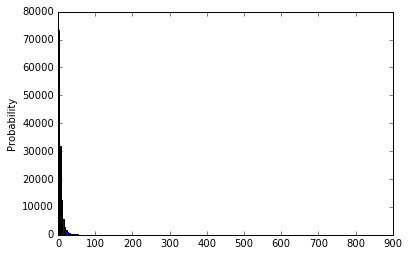

In [241]:
plt.hist(regression_data[0], normed=False, bins=208)
plt.ylabel('Probability')

In [240]:
dictArr

[{0: 3770,
  1: 29507,
  2: 22081,
  3: 17948,
  4: 9249,
  5: 9247,
  6: 7504,
  7: 5743,
  8: 4396,
  9: 3461,
  10: 2661,
  11: 2070,
  12: 1821,
  13: 1455,
  14: 1271,
  15: 1038,
  16: 909,
  17: 749,
  18: 680,
  19: 575,
  20: 523,
  21: 448,
  22: 396,
  23: 355,
  24: 333,
  25: 278,
  26: 258,
  27: 224,
  28: 205,
  29: 174,
  30: 151,
  31: 134,
  32: 119,
  33: 132,
  34: 84,
  35: 87,
  36: 83,
  37: 81,
  38: 83,
  39: 67,
  40: 55,
  41: 64,
  42: 54,
  43: 57,
  44: 51,
  45: 50,
  46: 46,
  47: 32,
  48: 44,
  49: 38,
  50: 34,
  51: 28,
  52: 28,
  53: 32,
  54: 23,
  55: 30,
  56: 19,
  57: 18,
  58: 27,
  59: 26,
  60: 15,
  61: 24,
  62: 17,
  63: 10,
  64: 23,
  65: 20,
  66: 14,
  67: 23,
  68: 13,
  69: 5,
  70: 11,
  71: 9,
  72: 11,
  73: 10,
  74: 10,
  75: 7,
  76: 10,
  77: 5,
  78: 12,
  79: 8,
  80: 7,
  81: 8,
  82: 8,
  83: 9,
  84: 10,
  85: 5,
  86: 4,
  87: 4,
  88: 10,
  89: 3,
  90: 3,
  91: 3,
  92: 7,
  93: 5,
  94: 4,
  95: 6,
  96: 6,
  97: 9

In [245]:
model = regression_models[0]
predicted = model.predict(PostsByCluster)
actual = regression_data[0]

In [248]:
predicted.tolist()

[5.333462384305411,
 5.851832354118098,
 5.193253407198732,
 5.224234624605756,
 5.301955296979567,
 5.157581488591974,
 5.56006882518124,
 5.21841892330674,
 5.207998046916952,
 5.550370227184938,
 5.133234067583829,
 5.931167484727342,
 6.79775427266587,
 5.443081707340772,
 5.31544403141666,
 5.198482304564619,
 5.406037190580671,
 6.148524125148278,
 5.198482304564619,
 5.198482304564619,
 5.8520716057277635,
 5.280359769755162,
 5.091599151596383,
 5.231805104988875,
 5.905401843861306,
 5.145650155039495,
 5.248672079092701,
 5.235994793773794,
 5.286862532141318,
 5.199148186992409,
 5.276236676360208,
 5.056708749920821,
 5.169576200093123,
 5.198243052954955,
 5.194000333755168,
 5.608350763865901,
 5.31598551558105,
 5.188846936407454,
 6.233111350438554,
 5.575127287633948,
 5.212345877114593,
 5.2128741343900495,
 5.107052674232494,
 5.555736925514784,
 5.911896748413011,
 5.198482304564619,
 5.1871137225424695,
 5.179211568250288,
 5.5153021449487,
 5.099975896107599,
 7.0

In [247]:
actual

[12,
 2,
 19,
 36,
 11,
 20,
 15,
 7,
 401,
 13,
 19,
 3,
 18,
 9,
 49,
 1,
 5,
 7,
 8,
 0,
 8,
 1,
 21,
 10,
 10,
 8,
 14,
 15,
 12,
 20,
 33,
 10,
 10,
 9,
 9,
 14,
 2,
 15,
 16,
 19,
 15,
 10,
 167,
 9,
 45,
 15,
 15,
 27,
 20,
 15,
 19,
 2,
 1,
 6,
 14,
 26,
 17,
 54,
 5,
 52,
 9,
 41,
 1,
 1,
 12,
 3,
 1,
 1,
 27,
 5,
 68,
 12,
 12,
 17,
 1,
 34,
 24,
 11,
 12,
 16,
 41,
 16,
 10,
 27,
 24,
 24,
 30,
 9,
 12,
 25,
 15,
 13,
 23,
 123,
 18,
 43,
 22,
 16,
 14,
 21,
 28,
 11,
 5,
 2,
 9,
 15,
 61,
 11,
 27,
 10,
 25,
 10,
 1,
 1,
 14,
 13,
 29,
 1,
 1,
 23,
 17,
 24,
 11,
 20,
 22,
 17,
 8,
 26,
 15,
 33,
 7,
 13,
 11,
 24,
 21,
 13,
 20,
 16,
 1,
 15,
 10,
 9,
 1,
 8,
 7,
 10,
 14,
 24,
 4,
 9,
 7,
 9,
 17,
 8,
 20,
 31,
 15,
 7,
 1,
 2,
 39,
 22,
 8,
 30,
 13,
 5,
 8,
 7,
 11,
 5,
 23,
 5,
 12,
 15,
 26,
 9,
 12,
 1,
 10,
 4,
 9,
 4,
 1,
 10,
 39,
 9,
 10,
 24,
 1,
 1,
 10,
 8,
 10,
 5,
 34,
 21,
 2,
 17,
 7,
 7,
 24,
 7,
 6,
 21,
 10,
 9,
 5,
 9,
 17,
 43,
 7,
 7,
 10,
 3,
 30,
 

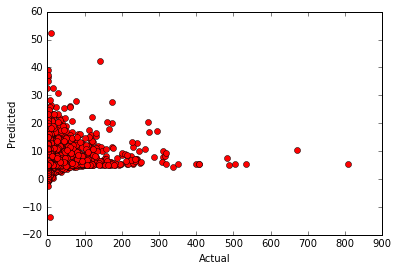

In [256]:
plt.plot(actual,predicted,"ro")
plt.xlabel("Actual")
plt.ylabel("Predicted")